# Quickstart

This introduction provides an overview of EHRData, a tool designed for analyzing data in OMOP CDM format. It facilitates multimodal data analysis, encompassing tables, time series, images, and text, making it suitable for a diverse range of datasets. 

# Loading and analyzing OMOP CDM Dataset

The Observational Medical Outcomes Partnership (OMOP) Common Data Model (CDM) is an open community data standard, designed to standardize the structure and content of observational data and to enable efficient analyses that can produce reliable evidence. 

Core tables usually are:  `Person, visit_occurrence, Condition_occurrence, Procedure_occurrence, Drug_exposure, Measurement, and Observation`. 

Here's the OMOP CDM schema:

<img src="https://ohdsi.github.io/CommonDataModel/images/cdm54.png" alt="OMOP CDM" width="1000">


We will start from a public available 100-patient demo dataset of MIMIC-IV in the OMOP CDM. 

(Source: https://physionet.org/content/mimic-iv-demo-omop/0.9/)

The data has been downloaded, preprocessed, and stored in `tests/mimic-iv-demo-OMOP-CDM-data` folder. Some columns have been renamed to adhere to the OMOP CDM standard.

In [1]:
# Import some libraries

import os

import ehrdata as ehr
import matplotlib.pyplot as plt

/opt/anaconda3/envs/ehrdata/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_to_omop_mimiciii = f"{path}/tests/mimic-iv-demo-OMOP-CDM-data"

## Loading Data

First, we can use `ehr.io.init_omop` to load the data into EHRData. As we can see, there are 22 tables in this dataset. And by default, it will load "visit_occurrence", "person", "death", "visit_detail", "provider" tables and join them together.

The viewing option is controlled by `level` parameter. The default value is "stay_level", which means the each row in ehrdata is a stay in hospital. If we set it to "patient_level", each row will be a patient and several hospital stays will be combined into one row.

In [3]:
ehrdata = ehr.io.init_omop(folder_path=path_to_omop_mimiciii, level="stay_level")

Checking if your data adheres to the OMOP Common Data Model (CDM) version 5.4 standards.


OMOP Database (mimic-iv-demo-OMOP-CDM-data) with 22 tables.
Clinical data tables: observation_period, drug_exposure, specimen, death, device_exposure, fact_relationship, 
measurement, condition_occurrence, visit_occurrence, person, observation, visit_detail, procedure_occurrence
Health system data tables: care_site, location
Standardized derived elements tables: dose_era, drug_era, condition_era
Metadata tables: cdm_source
Vocabulary tables: concept_relationship, vocabulary, concept

2024-03-18 23:29:24,653 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `852` x `0`.
Loading tables: {'person', 'death', 'visit_occurrence', 'visit_detail'}


## Exploring Data

### Basic Demographics of the Patients

In [4]:
print(f"Number of ICU stays: {len(ehrdata)}")
print(f"Number of patients: {len(ehrdata.obs['person_id'].unique())}")
print(f"Number of survivors: {len(ehrdata[ehrdata.obs['death_datetime'].isna()].obs['person_id'].unique())}")
print(f"Number of non-survivors: {len(ehrdata[~ehrdata.obs['death_datetime'].isna()].obs['person_id'].unique())}")
print(f"Number of male patients: {len(ehrdata[ehrdata.obs['gender_source_value'] == 'M'].obs['person_id'].unique())}")
print(f"Number of female patients: {len(ehrdata[ehrdata.obs['gender_source_value'] == 'F'].obs['person_id'].unique())}")

Number of ICU stays: 852
Number of patients: 100
Number of survivors: 85
Number of non-survivors: 15
Number of male patients: 57
Number of female patients: 43


Now we can use `ehr.pl.feature_counts` to see the number of features in core event tables. Supported tables include "observation", "measurement", "procedure_occurrence", "specimen", "device_exposure", "drug_exposure", "condition_occurrence".

we can use "number" argument to specify the number of top features to show. 

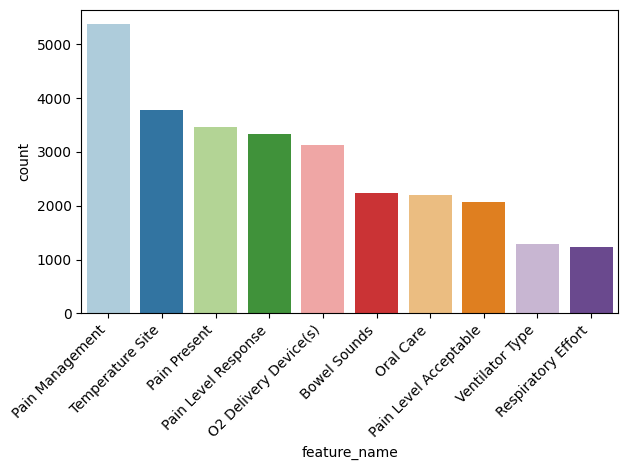

In [5]:
observation_count_df = ehr.pl.feature_counts(ehrdata, source="observation", number=10)

Couldn't find concept [0] in concept table!

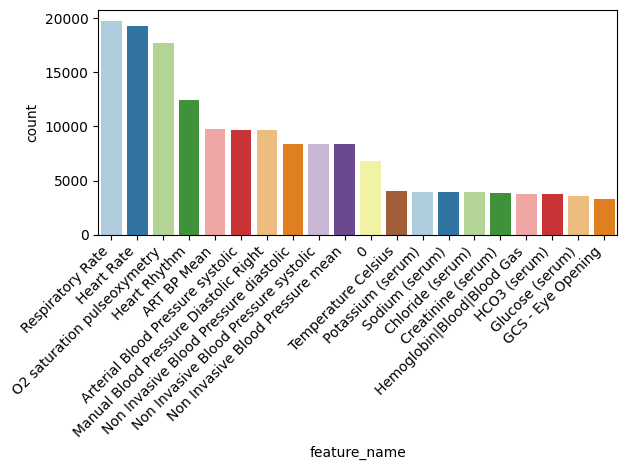

In [6]:
measurement_count_df = ehr.pl.feature_counts(ehrdata, source="measurement", number=20)

Couldn't find concept [0, 40220357, 40166274, 43011850, 19071700, 40167213] in concept table!

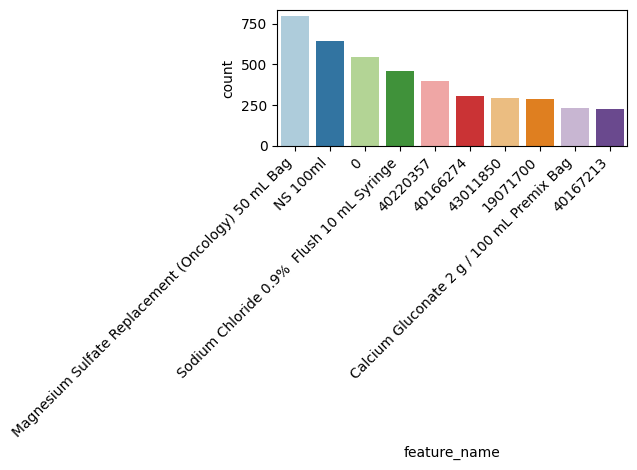

In [7]:
drug_exposure_count_df = ehr.pl.feature_counts(ehrdata, source="drug_exposure", number=10)

We can get aggregation statistics (`min/max/mean/count/std`) of selected features from core event tables


Using `ehr.pp.get_feature_statistics` to see the feature statistics in core event tables. Supported tables include "observation", "measurement", "procedure_occurrence", "specimen", "device_exposure", "drug_exposure", "condition_occurrence".

`features` argument is a list of features to show statistics. It can be feature name, feature id in concept table, or feature id in source enent table.

By using `add_aggregation_to`, we can add statistics to either `.obs` or `.X` or just return the statistics_df.

In [8]:
features = [
    "Respiratory Rate",
    2000030001,
    "O2 saturation pulseoxymetry",
    "Arterial Blood Pressure systolic",
    "Temperature Celsius",
    "Glucose (serum)",
]
# Here the feature_id of Heart Rate is 2000030001
measurement_statistics_df = ehr.pp.get_feature_statistics(
    ehrdata, add_aggregation_to="return", source="measurement", level="stay_level", features=features, verbose=True
)
measurement_statistics_df.head()

Detected: feature Respiratory Rate, feature ID 2000030002 in concept table, match ratio = 100.

Detected: feature Heart Rate, feature ID 2000030001 in concept table, match ratio = 100.

Detected: feature O2 saturation pulseoxymetry, feature ID 2000030003 in concept table, match ratio = 100.

Detected: feature Arterial Blood Pressure systolic, feature ID 2000030009 in concept table, match ratio = 100.

Detected: feature Temperature Celsius, feature ID 2000030092 in concept table, match ratio = 100.

Detected: feature Glucose (serum), feature ID 2000030072 in concept table, match ratio = 100.

Calculating statistics


,Respiratory Rate_min,Respiratory Rate_max,Respiratory Rate_mean,Respiratory Rate_std,Respiratory Rate_count,Heart Rate_min,Heart Rate_max,Heart Rate_mean,Heart Rate_std,Heart Rate_count,...,Temperature Celsius_min,Temperature Celsius_max,Temperature Celsius_mean,Temperature Celsius_std,Temperature Celsius_count,Glucose (serum)_min,Glucose (serum)_max,Glucose (serum)_mean,Glucose (serum)_std,Glucose (serum)_count
visit_occurrence_id,,,,,,,,,,,,,,,,,,,,,
-9176297757944464068,NaN,115.0,NaN,NaN,NaN,NaN,NaN,165.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
-9149771978458038515,NaN,106.0,84.0,93.0,9.0,98.1,NaN,170.0,147.0,99.0,...,22.113831,1.998188,3.924087,0.275379,NaN,10.0,26.0,24.0,26.0,4.0
-9133360720296560252,NaN,90.0,76.0,92.0,14.0,98.0,NaN,127.0,99.0,99.0,...,5.584733,1.838653,4.419410,1.028790,NaN,9.0,31.0,31.0,31.0,12.0
-9127810274408915712,NaN,86.0,NaN,NaN,NaN,NaN,NaN,86.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
-9115500683315376728,73.0,165.0,83.0,84.0,13.0,97.5,136.0,370.0,150.0,100.0,...,12.721206,2.451577,3.665969,0.294032,48.0,18.0,154.0,154.0,158.0,28.0


## Extract Data from core event tables

Now we use `ehr.pp.extract_features` to extract event data from core event tables. Supported tables include "observation", "measurement", "procedure_occurrence", "specimen", "device_exposure", "drug_exposure", "condition_occurrence".

In [9]:
ehrdata = ehr.io.extract_features(
    ehrdata,
    source="measurement",
    features=features,
    verbose=True,
    use_dask=True,
    source_table_columns=["measurement_datetime", "value_as_number", "unit_source_value"],
    dropna=True,
)

Reading measurement table
Adding feature [Respiratory Rate] from source table
Adding feature [Heart Rate] from source table
Adding feature [O2 saturation pulseoxymetry] from source table
Adding feature [Arterial Blood Pressure systolic] from source table
Adding feature [Temperature Celsius] from source table
Adding feature [Glucose (serum)] from source table


## Data preprocessing

### Outliers
#### Data visualization

We already saw that outliers are present in the dataset, but we need to take a closer look at data before deciding how to handle them. Using `ehrapy` and its `violin` plot function we can easily create one boxplot for every variable.

2024-03-18 23:29:30,039 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `19667` x `1`.
2024-03-18 23:29:30,263 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `19319` x `1`.
2024-03-18 23:29:30,474 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `17683` x `1`.
2024-03-18 23:29:30,669 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `9661` x `1`.
2024-03-18 23:29:30,803 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `3856` x `1`.
2024-03-18 23:29:30,905 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `3588` x `1`.


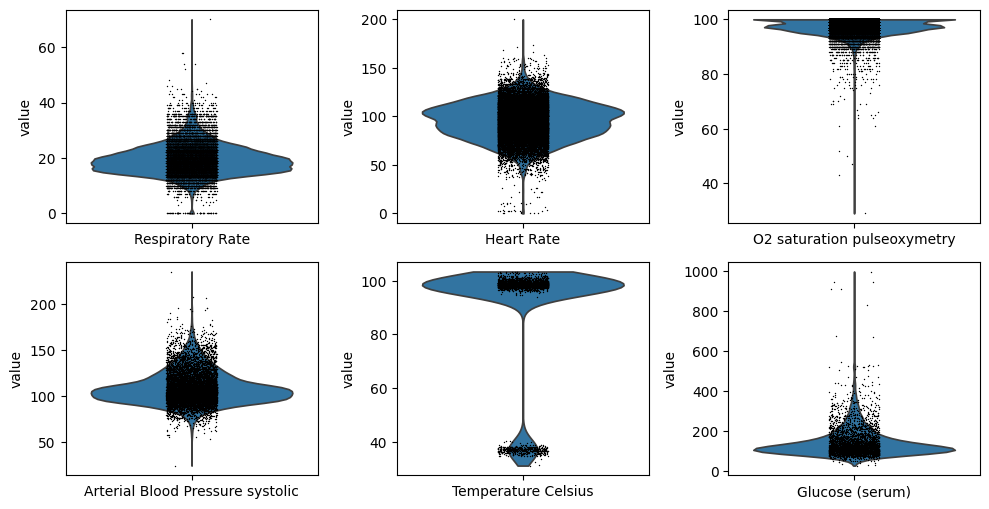

In [10]:
features = [
    "Respiratory Rate",
    "Heart Rate",
    "O2 saturation pulseoxymetry",
    "Arterial Blood Pressure systolic",
    "Temperature Celsius",
    "Glucose (serum)",
]
fig = plt.figure(figsize=(10, 10))
for i, variable in enumerate(features, start=1):
    ax = plt.subplot(4, 3, i)
    ehr.pl.violin(ehrdata, ax=ax, show=False, obsm_key=variable, keys=variable)
fig.tight_layout()
plt.show()

We can already see that some data inconsistencies are present in the dataset. For example, the `Temperature Celsius` variable also contains Temperature with unit `Fahrenheit`. 

## Data IO with EHRData

Time series data stored in EHRData can be easily exported using `ehr.io.to_dataframe` and imported using `ehr.io.from_dataframe` functions.

It turns out Temperature Celsius and Temperature Fahrenheit share same measurement_concept_id. So we need to do unit conversion before we can use the data.

In [11]:
df = ehr.io.to_dataframe(ehrdata, features="Temperature Celsius", keep_na=False)
df

,visit_occurrence_id,value_as_number,measurement_datetime,unit_source_value,measurement_concept_id,feature_name
619,4077761676343850739,98.2,2146-07-07 16:00:00,°F,3020891.0,Temperature Celsius
620,4077761676343850739,99.1,2146-06-30 00:00:00,°F,3020891.0,Temperature Celsius
621,4077761676343850739,99.1,2146-06-25 16:00:00,°F,3020891.0,Temperature Celsius
622,4077761676343850739,98.4,2146-07-08 08:00:00,°F,3020891.0,Temperature Celsius
623,4077761676343850739,99.1,2146-06-29 16:00:00,°F,3020891.0,Temperature Celsius
...,...,...,...,...,...,...
4703,3079807580745996118,99.4,2142-08-03 08:00:00,°F,3020891.0,Temperature Celsius
4704,3079807580745996118,98.2,2142-08-31 01:00:00,°F,3020891.0,Temperature Celsius
4705,3079807580745996118,98.3,2142-08-02 12:00:00,°F,3020891.0,Temperature Celsius
4706,3079807580745996118,99.2,2142-08-03 11:00:00,°F,3020891.0,Temperature Celsius


In [12]:
df.loc[df["unit_source_value"] == "°F", "value_as_number"] = (
    (df.loc[df["unit_source_value"] == "°F", "value_as_number"] - 32) * 5 / 9
)
df.loc[df["value_as_number"] > 90, "value_as_number"] = (
    (df.loc[df["value_as_number"] > 90, "value_as_number"] - 32) * 5 / 9
)
df.loc[df["unit_source_value"] == "°F", "unit_source_value"] = "°C"
df

,visit_occurrence_id,value_as_number,measurement_datetime,unit_source_value,measurement_concept_id,feature_name
619,4077761676343850739,36.777778,2146-07-07 16:00:00,°C,3020891.0,Temperature Celsius
620,4077761676343850739,37.277778,2146-06-30 00:00:00,°C,3020891.0,Temperature Celsius
621,4077761676343850739,37.277778,2146-06-25 16:00:00,°C,3020891.0,Temperature Celsius
622,4077761676343850739,36.888889,2146-07-08 08:00:00,°C,3020891.0,Temperature Celsius
623,4077761676343850739,37.277778,2146-06-29 16:00:00,°C,3020891.0,Temperature Celsius
...,...,...,...,...,...,...
4703,3079807580745996118,37.444444,2142-08-03 08:00:00,°C,3020891.0,Temperature Celsius
4704,3079807580745996118,36.777778,2142-08-31 01:00:00,°C,3020891.0,Temperature Celsius
4705,3079807580745996118,36.833333,2142-08-02 12:00:00,°C,3020891.0,Temperature Celsius
4706,3079807580745996118,37.333333,2142-08-03 11:00:00,°C,3020891.0,Temperature Celsius


In [13]:
ehrdata = ehr.io.from_dataframe(ehrdata, feature="Temperature Celsius", df=df)

2024-03-18 23:29:31,550 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `3856` x `1`.


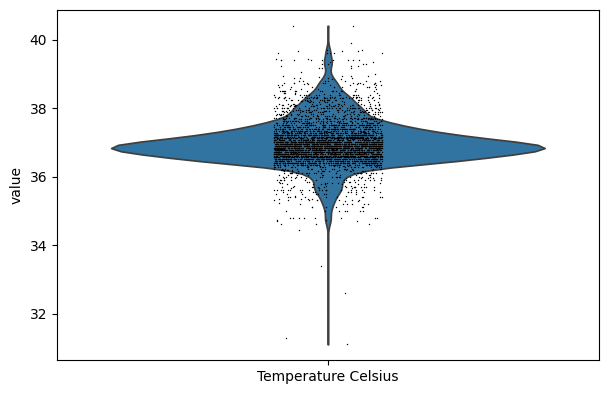

In [14]:
ehr.pl.violin(ehrdata, obsm_key="Temperature Celsius", keys="Temperature Celsius")

## Time series data visualization

The next example shows the vital signs for a specific ICU stay (ID = 2024697). Consecutive hourly observations are connected by line. 

<Axes: xlabel='Hours since ICU admission'>

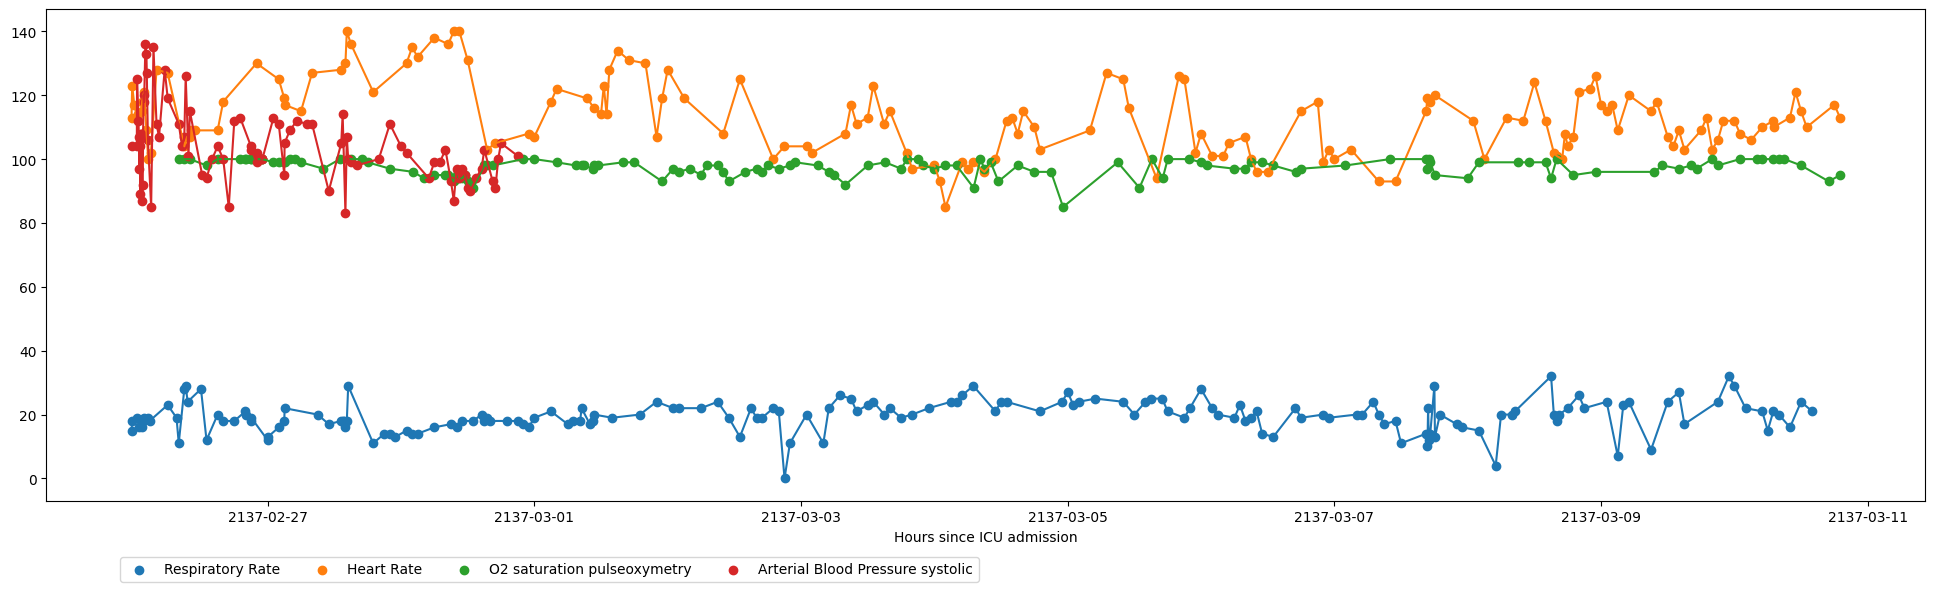

In [25]:
ehr.pl.plot_timeseries(
    ehrdata, visit_occurrence_id=ehrdata.obs.index[-2], key=features, time_key="measurement_datetime", to_time="2137-04"
)

# Citations

1. [OMOP CDM](https://ohdsi.github.io/CommonDataModel/) by OHDSI
2. [MIMIC-IV demo data in the OMOP Common Data Model](https://doi.org/10.13026/p1f5-7x35) Kallfelz, Michael, et al. "MIMIC-IV demo data in the OMOP Common Data Model" (version 0.9). PhysioNet (2021), .